## 1. Installation

In this section, we will go through the installation process by cloning the github repo

In [2]:
!git clone https://github.com/okbalefthanded/aawedha.git

Cloning into 'aawedha'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 563 (delta 4), reused 7 (delta 2), pack-reused 549
Receiving objects: 100% (563/563), 151.77 KiB | 12.65 MiB/s, done.
Resolving deltas: 100% (393/393), done.


In [0]:
%cd aawedha
!pip install -r requirements.txt
!python setup.py install 

## 2. Running an experiment 

In this section, we'll see how to use Aawedha in evaluating a ConvNet model, we'll use the Motor Imagery BCI Comp IV 2a dataset to demonstrate both types of analysis. First on Single Subject where we train the model and test it on data from a single subject, and secondly on Cross Subject where we train the model from data of different subjects and test on data from a target subject.

### 2.1 Create an epoched dataset

At the beginning, we'll select the dataset to analyze from the list available in Aawedha, and then create a dataset suitable for the upcoming operations. To do so we'll have to specify the preprocessing parameters such as the epoch length and band pass filter parameters.

In [4]:
# package imports
# dataset
from aawedha.io.bci_comp_iv_2a import Comp_IV_2a 
# evaluations
from aawedha.evaluation.single_subject import SingleSubject
from aawedha.evaluation.cross_subject import CrossSubject
# paradigms
from aawedha.paradigms.motor_imagery import MotorImagery 
from aawedha.paradigms.subject import Subject
# utils
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [0]:
# Here we're using Drive mounted in colab as Data storage location
data_folder = '/content/drive/My Drive/data/Comp_IV_Data_Set_IIa'
save_path = 'data/comp_IV_2a/'

# we only specify the epoch start and end relative to marker onset
# we can specify band pass filter low, high frequency cut-off and
# the filter order, but we keep the default values: [4. 40.] hz, order 3
t = [0.5 , 2.5]
ds = Comp_IV_2a()
ds.generate_set(load_path=data_folder, 
                epoch=t, 
                save_folder=save_path)

### 2.2 Define and run an Evaluation

Here, we got through the steps of how to define en evaluation and run a cross-validation on the dataset we've just created.

An *Evaluatio*n is the main class for doing experiments with **Aawedha**, we have to first load the data. a *DataSet* object has the main attributes of *epochs* and *y* that represents the data pairs: EEG epochs and True labels, note that for datasets with independent test set shipped apriori the *test_epochs* and *test_y* attributes represents the test data pairs. 
dataset.epochs /dataset.test_epochs are 4D tensors of shape: 
**Subjects x Samples x Channels x Trials**
this format is for datasets with consistent number of trials i.e. same number of trials for all subjects, in the opposite case dataset.epochs are a list of 3D tensors of shape **Samples x Channels x Trials** with len(list) = Subjects.

In [6]:
# load epoched dataset
f = 'data/comp_IV_2a/Comp_IV_2a.pkl'

dt = Comp_IV_2a().load_set(f)
subjects, samples, channels, trials = dt.epochs.shape
n_classes = np.unique(dt.y).size
print(f'BCI Comp IV 2a shape: Train data {dt.epochs.shape} Test data {dt.test_epochs.shape}')

BCI Comp IV 2a shape: Train data (9, 500, 22, 288) Test data (9, 500, 22, 288)


#### 2.2.1 Single subject evaluation

to set an *Evaluation* object, the dataset and the desired train/val/test partition are required, optional attributes such as verbosity level and logging option can be set at instation level (verbosity is used for model fitting progression, while logging is used for experiment information and results logging)

a partition is a list of integers, indicating the volume of data that each model evaluation phase will take, for single subject, the values indicate the portion of data from the total number of trials available in the subject's data, for example a **[2,1,1]** partition means that in training phase, 2 portions of data are kept, and the rest values are for validation and test phases.

In our example, the BCI Comp IV 2a data has an independent test set, so we only specify the portions of train and validation phase.

The *generate_split()* method creates a list of indices of trials for each fold, for single subject K-fold cross-validation strategy is the default data split method, Shufflesplit method can be set by adding an argument to the method : strategy='ShuffleSplit'. also the number of folds must be speficied.

We set the model by the set_model() method, a valid **Keras** model from the set of available ones must be set before running any evaluation. In this example we use the ShallowConvNet[1] model which a small ConvNet suitable for both small size data and fast computation. The models configuration can be set at this level too by passing a *dict* of configs, this configuration will be used later for the model's **compile()** and **fit()** methods

Reference:


[1] Schirrmeister R Springenberg J Fiederer L Glasstetter M Eggensperger K Tangermann M Hutter F Burgard W Ball T, Deep learning with convolutional neural networks for EEG decoding and visualization, Human Brain Mapping 2017 vol: 38 (11) pp: 5391-5420

In [7]:
# Note that throughout the toolbox we use the data representation
# format of channels first
from aawedha.models.EEGModels import ShallowConvNet
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')


# for short training, we set a small number of epochs
# and folds
config = {}
config['loss'] = 'categorical_crossentropy'
config['optimizer'] = 'adam'
config['metrics'] = ['accuracy']
config['batch'] = 64
config['epochs'] = 150
config['callbacks'] = []

evl = SingleSubject(partition=[2,1], dataset=dt, verbose=0, lg=False)

# generate folds 
evl.generate_split(nfolds=4) 
#
evl.set_model(model=ShallowConvNet(nb_classes=n_classes, Chans=channels, Samples=samples, dropoutRate=0.5),
              model_config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
# run Evaluation
# After setting the requirments for the experirment, we can run the evaluation
# All performance results will be stored in evl.results dict
evl.run_evaluation()

Evaluating Subject: 1/9...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Evaluating Subject: 2/9...
Evaluating Subject: 3/9...
Evaluating Subject: 4/9...
Evaluating Subject: 5/9...
Evaluating Subject: 6/9...
Evaluating Subject: 7/9...
Evaluating Subject: 8/9...
Evaluating Subject: 9/9...


In [9]:
# Results dictionary
evl.results

{'acc': array([[0.63888889, 0.61458333, 0.69097222, 0.65972222],
        [0.47569444, 0.53472222, 0.51388889, 0.51041667],
        [0.76388889, 0.78472222, 0.82986111, 0.78125   ],
        [0.56597222, 0.51736111, 0.55208333, 0.56597222],
        [0.51736111, 0.52777778, 0.54861111, 0.53125   ],
        [0.46180556, 0.47569444, 0.47222222, 0.48958333],
        [0.68402778, 0.64583333, 0.61805556, 0.64583333],
        [0.71527778, 0.75347222, 0.77777778, 0.79861111],
        [0.68055556, 0.70138889, 0.67013889, 0.63888889]]),
 'acc_mean': 0.6209490740740741,
 'acc_mean_per_fold': array([0.61149691, 0.61728395, 0.63040123, 0.6246142 ])}

### 2.2.2 Cross subject evaluation
The API is the same for Cross Subject evaluation, the only difference are in the partition values and folds, here the partition does not split data into trials but the whole set into subjects, i.e [8,1,1] means that data from 8 subjects will be merged into a big set and used to as training data, while a single subject data are used for validation and the last one will be used for test, note that the default setting exclude the target subject from training thus enforce a fully independent training (this option can be set to including the subject). Here a the data split is multiplied by the number of subjects, i.e.
nfolds = 1 will generate 1*Subjects (9 in BCI Comp IV 2a).


In [0]:
#
evl = CrossSubject(partition=[5,3], dataset=dt, verbose=0, lg=False)

# generate folds 
evl.generate_split(nfolds=1, excl=True) 
#
evl.set_model(model=ShallowConvNet(nb_classes=n_classes, Chans=channels, Samples=samples, dropoutRate=0.5),
              model_config=config)

In [0]:
evl.run_evaluation()

# 3 Visualizing experiment results

Aawedha providese vislualization methods for model inspecting and results reporting, currently learning curves, confusion matrix and individual subjects performances are the viz tools available.

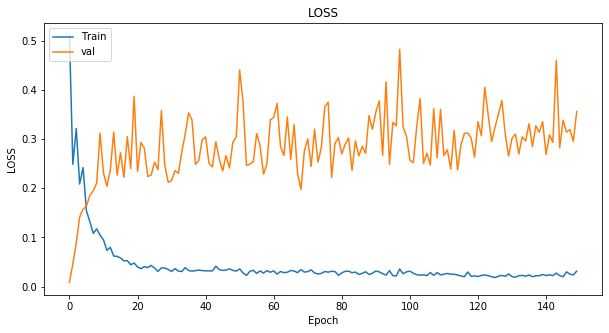

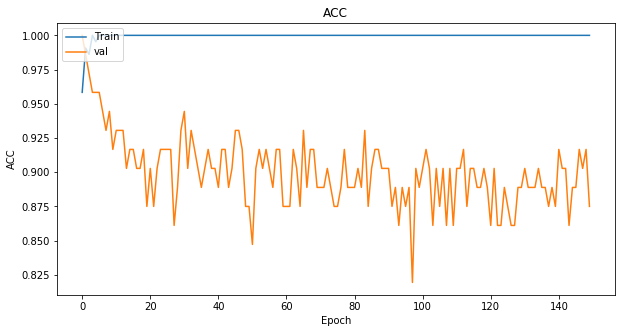

In [14]:
from aawedha.visualization.viz import plot_train_val_curve
plot_train_val_curve(evl.model_history.history)

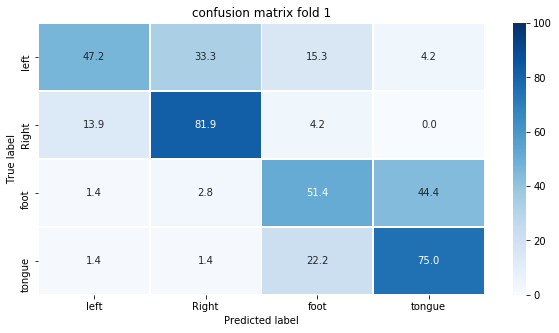

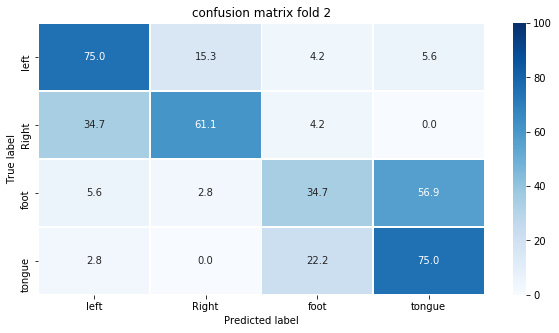

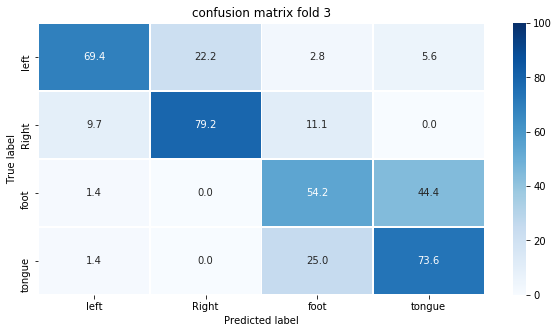

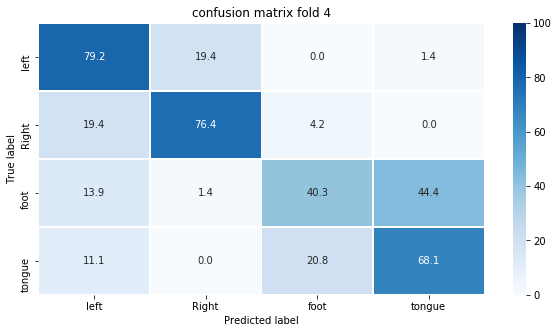

In [15]:
# confusion matrix of each fold
from aawedha.visualization.viz import plot_confusion_matrix
class_names = ['left', 'Right', 'foot','tongue']

for fld in range(len(evl.folds)):
  g = plot_confusion_matrix(evl.cm[fld], class_names,
                      title=f'confusion matrix fold {fld+1}')

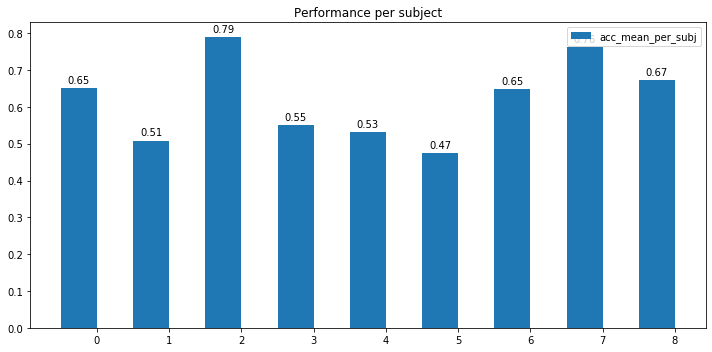

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f16e49b9470>)

In [13]:
# For single subject evaluation
from aawedha.visualization.viz import plot_subjects_perf
evl.results['acc_mean_per_subj'] = evl.results['acc'].mean(axis=1)
plot_subjects_perf(results=evl.results)

# 4 Conclusion

We had seen in this notebook, the main concepts in Aawedha and the regular usage, the advanced features available such as evaluation **resume** after interruption using **checkpoint** and model saving and deploying will be covered in the upcoming tutorials.